<a href="https://colab.research.google.com/github/AnjanaGJoseph/Climate-Classification/blob/master/climate_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Climate classification



##Data Preprocessing

In [1]:
import tensorflow as tf
import pandas as pd
import os
import io
import tarfile
import numpy as np
import random
from shutil import copyfile
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
from matplotlib.image import imread
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import log_loss
import tensorflow as tf

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!kaggle datasets download -d vijaygiitk/multiclass-weather-dataset

 96% 129M/134M [00:15<00:00, 14.3MB/s]
100% 134M/134M [00:15<00:00, 8.88MB/s]


In [4]:
!unzip -q multiclass-weather-dataset.zip

In [5]:
path = ('/content/drive/My Drive/Weather_Predictions/')

##Distribution of the dataset's five different classes 

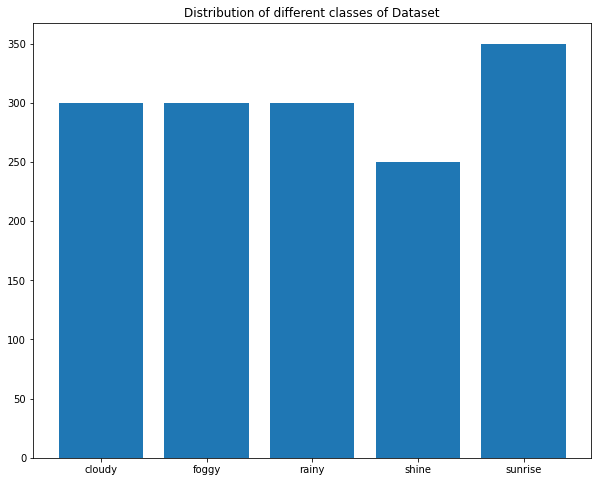

In [6]:
image_folder = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/dataset/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(10, 8))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes of Dataset')
plt.show()

##Distribution of the image size in each class

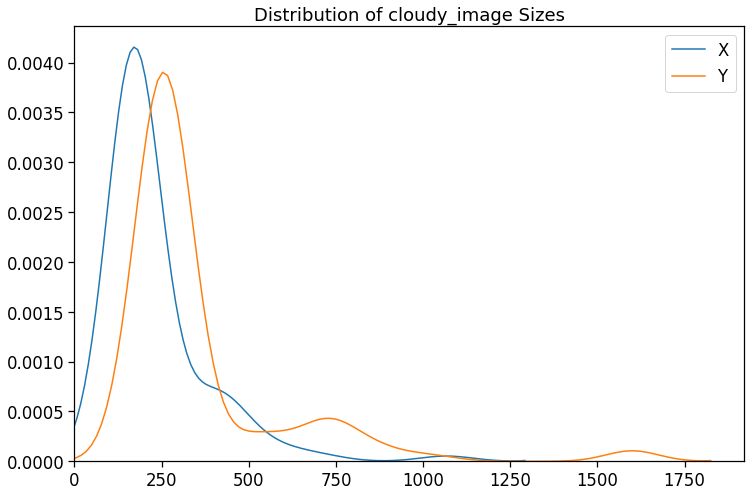

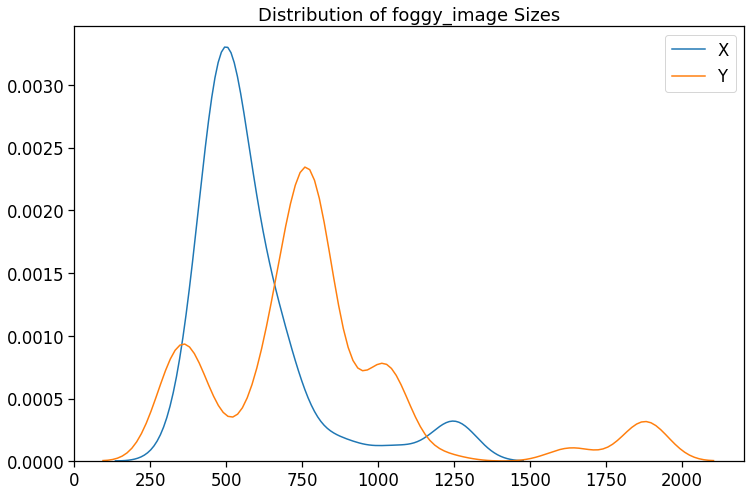

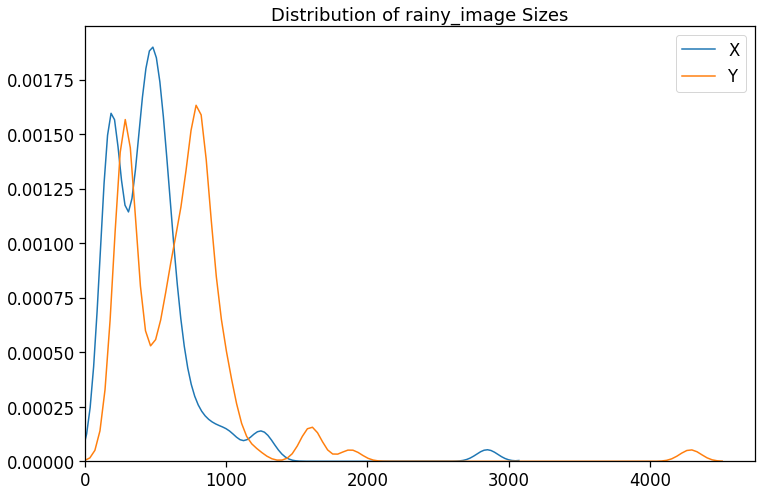

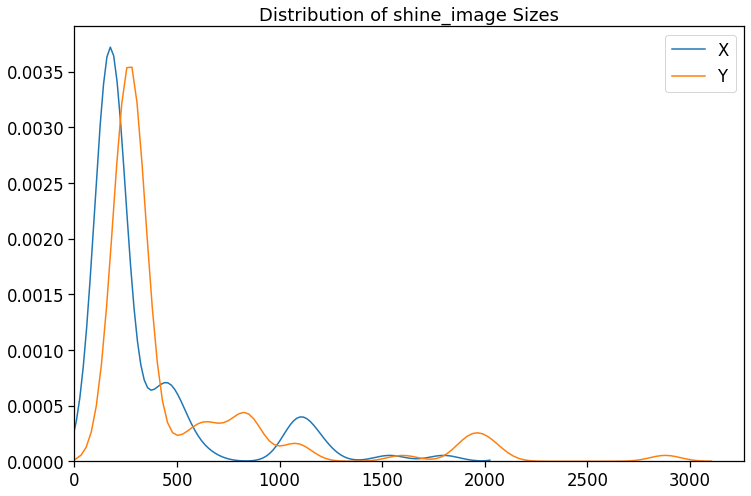

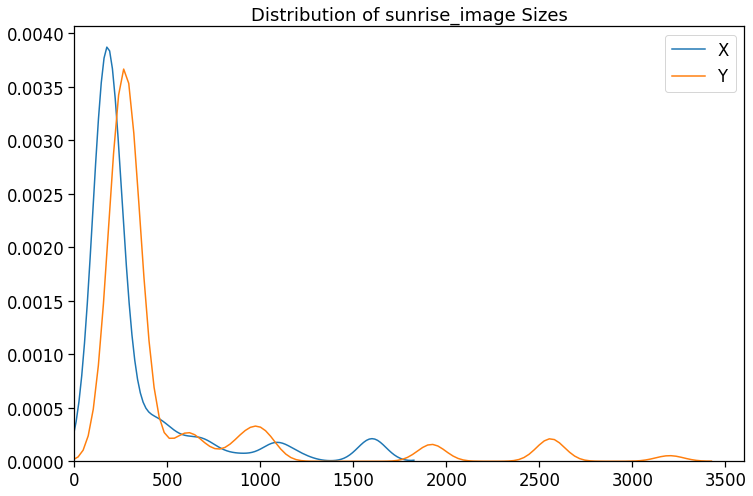

In [7]:
image_folder = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

for i in image_folder:
    sample_images = list(pathlib.Path('/content/dataset/'+i+'/').rglob('*/'))
    np.random.seed(42)
    rand_imgs = np.random.choice(sample_images, size=10*10)

    shapes = []
    for img in rand_imgs:
        shapes.append(imread(str(img)).shape)
    
    shapes = pd.DataFrame().assign(X=pd.Series(shapes).map(lambda s: s[0]), Y=pd.Series(shapes).map(lambda s: s[1]))
    
    plt.figure(figsize=(12, 8))
    sns.set_context("notebook", font_scale=1.5)
    sns.kdeplot(shapes['X'], bw=75)
    sns.kdeplot(shapes['Y'], bw=75)
    plt.title('Distribution of {}_image Sizes'.format(i))
    ax = plt.gca()
    ax.set_xlim(0, ax.get_xlim()[1])


##Creating train and test directories

In [8]:
try:
  os.mkdir('/content/dataset2')
  os.mkdir('/content/dataset2/Data')
  os.mkdir('/content/dataset2/Data/training')
  os.mkdir('/content/dataset2/Data/validation')
  os.mkdir('/content/dataset2/Data/training/cloudy')
  os.mkdir('/content/dataset2/Data/training/foggy')
  os.mkdir('/content/dataset2/Data/training/rainy')
  os.mkdir('/content/dataset2/Data/training/shine')
  os.mkdir('/content/dataset2/Data/training/sunrise')
  os.mkdir('/content/dataset2/Data/validation/cloudy')
  os.mkdir('/content/dataset2/Data/validation/foggy')
  os.mkdir('/content/dataset2/Data/validation/rainy')
  os.mkdir('/content/dataset2/Data/validation/shine')
  os.mkdir('/content/dataset2/Data/validation/sunrise')
except OSError: 
  pass

## Function to split the data into train and test 

In [9]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)


In [10]:
CLOUDY_SOURCE_DIR = '/content/dataset/cloudy/'
TRAINING_CLOUDY_DIR = '/content/dataset2/Data/training/cloudy/'
VALID_CLOUDY_DIR = '/content/dataset2/Data/validation/cloudy/'

FOGGY_SOURCE_DIR = '/content/dataset/foggy/'
TRAINING_FOGGY_DIR = '/content/dataset2/Data/training/foggy/'
VALID_FOGGY_DIR = '/content/dataset2/Data/validation/foggy/'

RAINY_SOURCE_DIR = '/content/dataset/rainy/'
TRAINING_RAINY_DIR = '/content/dataset2/Data/training/rainy/'
VALID_RAINY_DIR = '/content/dataset2/Data/validation/rainy/'

SHINE_SOURCE_DIR = '/content/dataset/shine/'
TRAINING_SHINE_DIR = '/content/dataset2/Data/training/shine/'
VALID_SHINE_DIR = '/content/dataset2/Data/validation/shine/'

SUNRISE_SOURCE_DIR = '/content/dataset/sunrise/'
TRAINING_SUNRISE_DIR = '/content/dataset2/Data/training/sunrise/'
VALID_SUNRISE_DIR = '/content/dataset2/Data/validation/sunrise/'


In [11]:
split_size = .85
split_data(CLOUDY_SOURCE_DIR, TRAINING_CLOUDY_DIR, VALID_CLOUDY_DIR, split_size)
split_data(FOGGY_SOURCE_DIR, TRAINING_FOGGY_DIR, VALID_FOGGY_DIR, split_size)
split_data(RAINY_SOURCE_DIR, TRAINING_RAINY_DIR, VALID_RAINY_DIR, split_size)
split_data(SHINE_SOURCE_DIR, TRAINING_SHINE_DIR, VALID_SHINE_DIR, split_size)
split_data(SUNRISE_SOURCE_DIR, TRAINING_SUNRISE_DIR, VALID_SUNRISE_DIR, split_size)


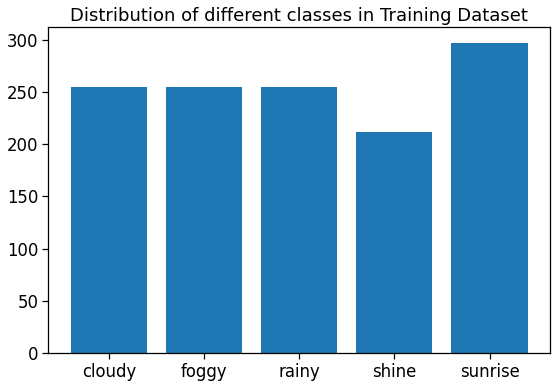

In [12]:
image_folder = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/dataset2/Data/training/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

In [13]:
for i in ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']:
    print('Training {} images are: '.format(i)+str(len(os.listdir('/content/dataset2/Data/training/'+i+'/'))))


Training cloudy images are: 255
Training foggy images are: 255
Training rainy images are: 255
Training shine images are: 212
Training sunrise images are: 297


## Visualization

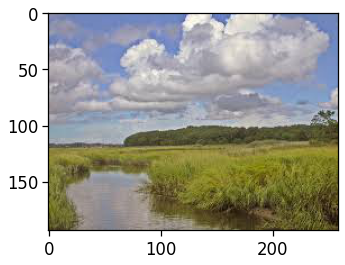

In [14]:
sample_data = mpimg.imread("/content/dataset2/Data/training/cloudy/cloudy100.jpg")
img = plt.imshow(sample_data)


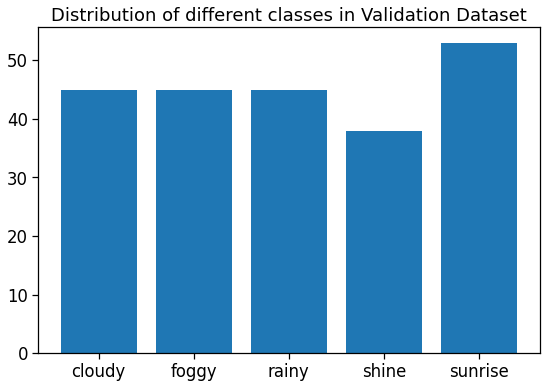

In [15]:
mimage_folder = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/dataset2/Data/validation/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()


In [16]:
for i in ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']:
    print('Valid {} images are: '.format(i)+str(len(os.listdir('/content/dataset2/Data/validation/'+i+'/'))))


Valid cloudy images are: 45
Valid foggy images are: 45
Valid rainy images are: 45
Valid shine images are: 38
Valid sunrise images are: 53


##Training

In [17]:
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [18]:
img_width=256; img_height=256
batch_size=15

## Augmentation

In [19]:
TRAINING_DIR = '/content/dataset2/Data/training/'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   featurewise_std_normalization=True,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=True)  # divide each input by its std
                                   #zca_whitening=False,  # apply ZCA whitening
                                   #zoom_range = 0.1, # Randomly zoom image 
                                   #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   #vertical_flip=False,
                                   #horizontal_flip=False)
#train_datagen.fit(image_folder)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [20]:
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))



Found 1274 images belonging to 5 classes.


In [21]:
VALIDATION_DIR = '/content/dataset2/Data/validation/'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [22]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )


Found 226 images belonging to 5 classes.


In [23]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
best_model_file = '../weather_pred/vgg16_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)
#reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)



In [24]:
wp = '/content/drive/My Drive/Weather_Prediction/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_base = VGG16(include_top=False, weights=wp,
                   input_tensor=None, input_shape=(img_height, img_width, 3))



##adding new layers 

In [25]:
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(5, activation='softmax')(output)

In [26]:
vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False
vgg16_model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [27]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)


In [28]:
vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

In [29]:
history = vgg16_model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator,
                              #callbacks = [callbacks, best_model]
                              )


Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
85/85 [==============================] - 33s 388ms/step - loss: 0.8366 - accuracy: 0.7802 - val_loss: 10.9318 - val_accuracy: 0.7920
Epoch 2/15
85/85 [==============================] - 32s 377ms/step - loss: 0.4151 - accuracy: 0.8838 - val_loss: 7.8387 - val_accuracy: 0.8584
Epoch 3/15
85/85 [==============================] - 32s 380ms/step - loss: 0.2702 - accuracy: 0.9239 - val_loss: 3.7506 - val_accuracy: 0.8894
Epoch 4/15
85/85 [==============================] - 33s 385ms/step - loss: 0.1863 - accuracy: 0.9364 - val_loss: 6.9764 - val_accuracy: 0.8186
Epoch 5/15
85/85 [==============================] - 33s 386ms/step - loss: 0.1958 - accuracy: 0.9435 - val_loss: 6.3907 - val_accuracy: 0.8717
Epoch 6/15
85/85 [==============================] - 33s 384ms/step - loss: 0.1695 - accuracy: 0.9537 - val_loss: 10.5384 - val_accuracy: 0.7920
Epoch 7/15
85/85 [==============================] - 32s 381ms/step - loss: 0.1239 - accuracy: 0.9576 - val_loss: 6.9290 - val_accuracy: 0.84

In [30]:
target_dir = '/content/drive/My Drive/Weather_Prediction/weights/self_trained/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
vgg16_model.save(target_dir + 'vgg16_model_256.h5')
vgg16_model.save_weights(target_dir + 'vgg16_weights_256.h5')


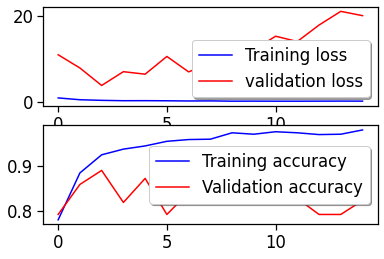

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [32]:
#test_preprocessed_images = np.load('/content/drive/My Drive/Weather_Prediction/test_preproc_resnet.npy')
#print(test_preprocessed_images)
#test_preprocessed_images1 = '/content/dataset/test.csv'
test_dir= '/content/drive/My Drive/Weather_Prediction/test'

test_datagen = ImageDataGenerator(preprocessing_function= None,
                                  featurewise_std_normalization= True,
                                  samplewise_std_normalization = False)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [33]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))


Found 30 images belonging to 5 classes.


In [34]:
#model_path = '/content/drive/My Drive/Weather_Prediction/weights/vgg16_drop_best_weights_256.h5'
model_path = '/content/drive/My Drive/Weather_Prediction/weights/self_trained/vgg16_model_256.h5'

In [35]:
model = load_model(model_path)

In [36]:
array = model.predict(test_generator)
#print(array)
y_pred = np.argmax(array, axis=1)
#print(y_pred)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [37]:
test_df = pd.read_csv('/content/dataset/test.csv')
y_true = test_df['labels']
#print(y_true)

In [38]:
train_dir = '/content/dataset2/Data/training/'
classes = os.listdir(train_dir)

In [39]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)


In [40]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


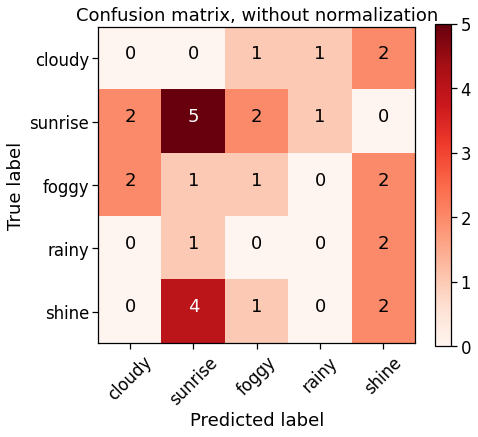

In [41]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
#fig1.savefig('../cm_wo_norm.jpg')
plt.show()
